In [181]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [182]:
# Krok 1.1: Definice modelu neuronové sítě 
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(2, 20)  # Vstup je 2D, proto 2 vstupy (x,y)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(20, 20)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(20, 20)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(20, 20)
        self.tanh4 = nn.Tanh()
        self.fc5 = nn.Linear(20, 20)
        self.tanh5 = nn.Tanh()
        self.fc6 = nn.Linear(20, 1)  # Výstup je skalár u(x,y)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh1(x)
        x = self.fc2(x)
        x = self.tanh2(x)
        x = self.fc3(x)
        x = self.tanh3(x)
        x = self.fc4(x)
        x = self.tanh4(x)
        x = self.fc5(x)
        x = self.tanh5(x)
        x = self.fc6(x)
        return x

In [183]:
# Krok 1.2: Funkce pro generování rovnoměrně rozložených trénovacích dat
def generate_inner_train_data(no_points): # Body uvnitř oblasti
    t = torch.linspace(0, 1, int(torch.sqrt(torch.tensor(no_points)))) 
    x = torch.linspace(-1, 1, int(torch.sqrt(torch.tensor(no_points)))) 
    T, X = torch.meshgrid(t, x)

    t = T.reshape(-1, 1)
    x = X.reshape(-1, 1)
    
    points_in = (t < 1 - 1e-3) & (t > 1e-3) & (torch.abs(x) < 1 - 1e-3)

    t_train = t[points_in].view(-1, 1)
    x_train = x[points_in].view(-1, 1)

    return (t_train, x_train)

def generate_boundaries(no_points): # Body na hranici
    t_bottom = torch.linspace(0,1, no_points).view(-1, 1)
    x_bottom = -1*torch.ones_like(t_bottom)
    x_left = torch.linspace(-1, 1, no_points).view(-1, 1)
    t_left = torch.zeros_like(x_left)
    t_top = torch.linspace(0, 1, no_points).view(-1, 1)
    x_top = torch.ones_like(t_top)

    return (t_bottom, x_bottom, t_top, x_top, t_left, x_left)

In [184]:
# Krok 1.2: Funkce pro vykreslení trénovacích bodů
def plot_boundaries(t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left):
    plt.figure(figsize=(12, 6))
    plt.scatter(t_bottom.numpy(), x_bottom.numpy(), label="Bottom",s=5, color='blue')
    plt.scatter(t_top.numpy(), x_top.numpy(), label="Top",s=5, color='green')
    plt.scatter(t_left.numpy(), x_left.numpy(), label="Left",s=5, color='red')
    plt.scatter(t_train.numpy(), x_train.numpy(), label="Trénovací data",s=10, color='yellow')
    plt.axhline(0, color='black',linewidth=1)
    plt.axvline(0, color='black',linewidth=1)
    plt.title("Hranice")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    #plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    return

In [185]:
# Krok 1.3: Funkce pro výpočet derivací
def compute_derivatives_2d(model, x, y): # Výpočet derivací pomocí funkce autograd z knihovny PyTorch
    inputs = torch.hstack((x,y)).requires_grad_(True)
    u = model(inputs)
    
    # První derivace
    u_x = grad(u, inputs, torch.ones_like(u), create_graph=True)[0][:, 0:1]  # du/dx
    u_y = grad(u, inputs, torch.ones_like(u), create_graph=True)[0][:, 1:2]  # du/dy
    
    # Druhé derivace
    u_xx = grad(u_x, inputs, torch.ones_like(u_x), create_graph=True)[0][:, 0:1]  # d²u/dx²
    u_yy = grad(u_y, inputs, torch.ones_like(u_y), create_graph=True)[0][:, 1:2]  # d²u/dy²
    
    return (u, u_x, u_y, u_xx, u_yy)

In [186]:
def exact_solution(t_data, x_data):
    u = (1*x_data + 3*torch.ones_like(x_data))/(t_data + torch.ones_like(t_data))
    return u

In [187]:
# Krok 2: Definice ztrátové funkce
def compute_loss(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left):
    # PDR ztráta
    u_train, u_t_train, u_x_train, _, _ = compute_derivatives_2d(model, t_train, x_train) # Výpočet derivací
    pde_loss = torch.mean((-(u_t_train + u_train * u_x_train))**2)
    
    # Ztráta na levé hranici
    u_left = model(torch.cat([t_left, x_left], dim=1))
    left_loss = torch.mean((u_left - (x_left+3*torch.ones_like(x_left)))**2)

    u_top = model(torch.cat([t_top, x_top], dim=1))
    top_loss = torch.mean((u_top - (1*torch.ones_like(t_top)+3*torch.ones_like(t_top))/(1*t_top+1*torch.ones_like(t_top)))**2)

    u_bottom = model(torch.cat([t_bottom, x_bottom], dim=1))
    bottom_loss = torch.mean((u_bottom - (-1*torch.ones_like(t_top)+3*torch.ones_like(t_top))/(1*t_top+1*torch.ones_like(t_top)))**2)

    # Celková ztráta
    total_loss = pde_loss + left_loss + top_loss + bottom_loss
    return total_loss

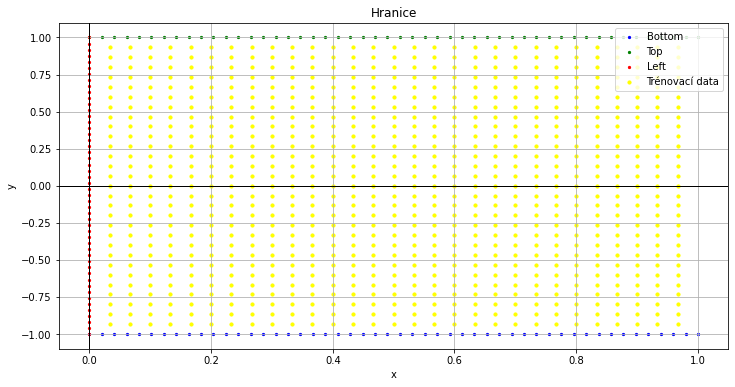

In [188]:
# Krok 3: Vygenerování trénovacích dat
t_train, x_train = generate_inner_train_data(1000) # Body uvnitř oblasti
t_bottom, x_bottom, t_top, x_top, t_left, x_left = generate_boundaries(50) # Body na hranici oblasti]

plot_boundaries(t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left) # Vykreslení trénovacích dat

In [189]:
def closure():
    optimizer.zero_grad()

    loss = compute_loss(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left)

    loss.backward(retain_graph=True)
    return loss

In [190]:
# Krok 4: Inicializace modelu a optimalizátoru
model = MyModel()
optimizer = optim.Adam(model.parameters(), lr=5e-3) 

In [191]:
# Krok 5.1: Trénovací smyčka
loss_values = [] # Seznam pro ukládání ztráty v každé epoše
epochs = 2000
best_loss = float('inf')
best_epoch = -1 
best_model_state_dict = None
for epoch in range(epochs):
    if epoch <= 3*epochs/4:
        optimizer.zero_grad()
    
        # Výpočet ztráty
        loss = compute_loss(model, t_train, x_train, t_bottom, x_bottom, t_top, x_top, t_left, x_left)

        loss.backward() # Backward pass
        optimizer.step() # Optimalizace
    else:
        loss = optimizer.step(closure)

    if epoch == 3*epochs/4:
        print(f"Změna optimalizátoru v epoše {epoch + 1}. Použití NN s nejlepší ztrátou {best_loss:.6f}")
        model.load_state_dict(best_model_state_dict)
        optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=20, history_size=10)

    loss_values.append(loss.detach().numpy())

    if loss.item() < best_loss:
        best_loss = loss.item()
        best_epoch = epoch
        best_model_state_dict = model.state_dict()

    if (epoch + 1) % 100 == 0:
        print(f'Epocha {epoch+1}/{epochs}, Ztráta: {loss.item()}')

Epocha 100/2000, Ztráta: 0.03420272096991539
Epocha 200/2000, Ztráta: 0.002145573729649186
Epocha 300/2000, Ztráta: 0.0010885174851864576
Epocha 400/2000, Ztráta: 0.0006902958848513663
Epocha 500/2000, Ztráta: 0.0004963481915183365
Epocha 600/2000, Ztráta: 0.00037393797538243234
Epocha 700/2000, Ztráta: 0.0002857171930372715
Epocha 800/2000, Ztráta: 0.0010658374521881342
Epocha 900/2000, Ztráta: 0.0001839896140154451
Epocha 1000/2000, Ztráta: 0.00014007389836478978
Epocha 1100/2000, Ztráta: 0.00022023161000106484
Epocha 1200/2000, Ztráta: 9.470030636293814e-05
Epocha 1300/2000, Ztráta: 7.097005436662585e-05
Epocha 1400/2000, Ztráta: 0.0003898468567058444
Epocha 1500/2000, Ztráta: 5.351232903194614e-05
Změna optimalizátoru v epoše 1501. Použití NN s nejlepší ztrátou 0.000054
Epocha 1600/2000, Ztráta: 3.665009899123106e-06
Epocha 1700/2000, Ztráta: 3.665009899123106e-06
Epocha 1800/2000, Ztráta: 3.665009899123106e-06
Epocha 1900/2000, Ztráta: 3.665009899123106e-06
Epocha 2000/2000, Ztrát

Nejlepší epocha 1534, Ztráta: 3.6650044421548955e-06


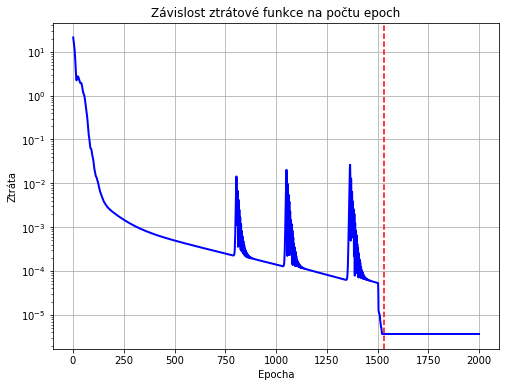

In [192]:
# Krok 5.2: Graf znázorňující závislost ztráty na počtu epoch
best_epoch = min(loss_values)
best_epoch_idx = loss_values.index(best_epoch)
print(f'Nejlepší epocha {best_epoch_idx}, Ztráta: {best_epoch}')

plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), loss_values, color='blue', linewidth=2)
plt.axvline(best_epoch_idx, color='r', linestyle='--', label='Nejlepší epocha')
plt.yscale('log')
plt.title('Závislost ztrátové funkce na počtu epoch')
plt.xlabel('Epocha')
plt.ylabel('Ztráta')
plt.grid(True)
plt.show()

In [209]:
# Krok 6.1: Funkce pro vygenerování testovacích dat v oblasti Omega (i na její hranici)
def generate_test_data(no_points):
    t = torch.rand(no_points, 1)
    x = torch.rand(no_points, 1) * 2 - 1
    t_test = t.view(-1, 1)
    x_test = x.view(-1, 1)

    return (t_test, x_test)

def generate_test_data_lhs(no_points):
    # Calculate the number of points for inside and boundary
    no_inside_points = int(no_points * 0.9)
    no_boundary_points = no_points - no_inside_points

    # Function for Latin Hypercube Sampling
    def latin_hypercube_sampling(num_samples, dim):
        # Create the grid of intervals
        grid = torch.linspace(0, 1, num_samples + 1)[:-1].unsqueeze(1)  # Exclude upper bound and reshape to (num_samples, 1)
        grid = grid + (torch.rand(num_samples, dim) / num_samples)  # Add randomness in the intervals
        # Shuffle the intervals along each dimension
        for d in range(dim):
            grid[:, d] = grid[torch.randperm(num_samples), d]
        return grid

    # Generate inside points using LHS
    lhs_inside = latin_hypercube_sampling(no_inside_points, 2)
    x_inside = lhs_inside[:, 0:1]  # Extract x coordinates
    y_inside = lhs_inside * 2 - 1
    y_inside = y_inside[:, 1:2]  # Extract y coordinates

    # Generate boundary points
    lhs_boundary = latin_hypercube_sampling(no_boundary_points, 1)
    side_assignments = torch.randint(0, 4, (no_boundary_points,)) 
    x_boundary = torch.zeros(no_boundary_points, 1)
    y_boundary = torch.zeros(no_boundary_points, 1)

    # Assign points to sides: 0 -> top, 1 -> bottom, 2 -> left, 3 -> right
    x_boundary[side_assignments == 0] = lhs_boundary[side_assignments == 0]
    y_boundary[side_assignments == 0] = 1

    x_boundary[side_assignments == 1] = lhs_boundary[side_assignments == 1]
    y_boundary[side_assignments == 1] = -1

    x_boundary[side_assignments == 2] = 0
    y_boundary[side_assignments == 2] = lhs_boundary[side_assignments == 2]

    x_boundary[side_assignments == 3] = 1
    y_boundary[side_assignments == 3] = lhs_boundary[side_assignments == 3]

    # Combine inside and boundary points
    x_test = torch.cat((x_inside, x_boundary), dim=0)
    y_test = torch.cat((y_inside, y_boundary), dim=0)

    return (x_test, y_test)

torch.Size([1000, 2])


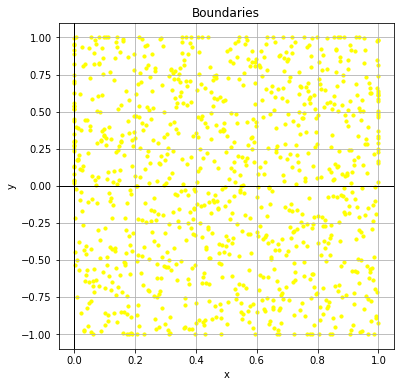

In [211]:
# lhs data generating plot
x_test, y_test = generate_test_data_lhs(1000)
inputs = torch.cat([x_test, y_test], dim=1) # Spojení x, y
print(inputs.size())
plt.figure(figsize=(6, 6))
plt.scatter(x_test.numpy(), y_test.numpy(),s=10, color='yellow')
plt.axhline(0, color='black',linewidth=1)
plt.axvline(0, color='black',linewidth=1)
plt.title("Boundaries")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [212]:
# Krok 6.2: Vygenerování testovacích dat a otestování NN
t_test, x_test = generate_test_data_lhs(2000)
model = MyModel()  # Initialize the model (same architecture as during training)
model.load_state_dict(best_model_state_dict)
#model.eval()

with torch.no_grad():
    inputs = torch.cat([t_test, x_test], dim=1)
    u_pred = model(inputs) 

u_pred_np = u_pred.numpy()

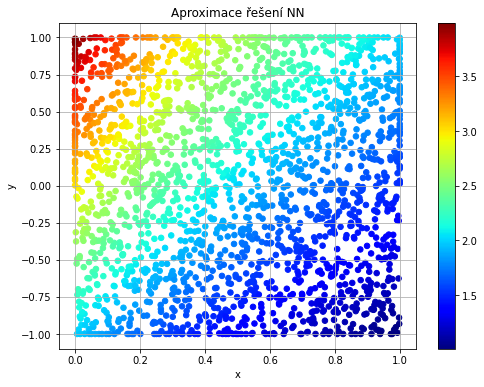

In [213]:
# Krok 6.3: Vykreslení aproximace NN řešení zadané úlohy
plt.figure(figsize=(8, 6))
plt.scatter(t_test.numpy(), x_test.numpy(), c=u_pred_np, cmap='jet', s=30)
plt.colorbar()
plt.title('Aproximace řešení NN')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

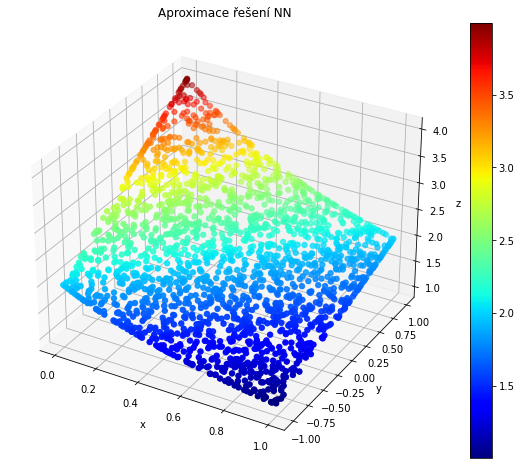

In [214]:
# Krok 6.4: Vykreslení aproximace NN řešení zadané úlohy ve 3D grafu
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(t_test.numpy(), x_test.numpy(), u_pred_np, c=u_pred_np, cmap='jet', s=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Aproximace řešení NN')
cbar = plt.colorbar(ax.scatter(t_test.numpy(), x_test.numpy(), u_pred_np, c=u_pred_np, cmap='jet', s=20), ax=ax)
plt.show()

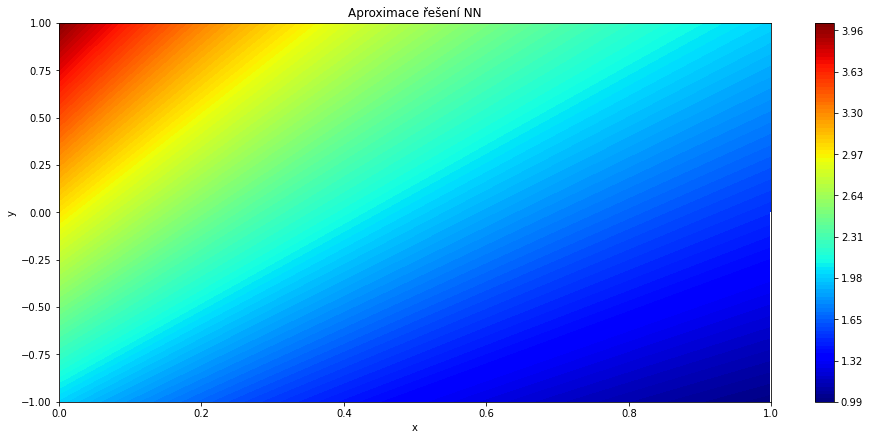

In [222]:
# Krok 6.5: Vykreslení aproximace NN řešení zadané úlohy ve 2D grafu s interpolací
t_test, x_test = generate_test_data_lhs(15000)

with torch.no_grad():
    inputs = torch.cat([t_test, x_test], dim=1)
    u_pred = model(inputs) 

# Interpolace
fig, axes = plt.subplots(1, 1, figsize=(12, 6), constrained_layout=True)

t = t_test.detach().cpu().numpy().squeeze()
x = x_test.detach().cpu().numpy().squeeze()

z = u_pred.detach().cpu().numpy().squeeze()

grid_t, grid_x = np.linspace(0, 1, 500), np.linspace(-1, 1, 500)
grid_t, grid_x = np.meshgrid(grid_t, grid_x)

grid_z = griddata((t, x), z, (grid_t, grid_x), method="linear")

# Vykraslení
ax = axes
im = ax.contourf(grid_t, grid_x, grid_z, levels=100, cmap="jet", vmin=None, vmax=None)
fig.colorbar(im, ax=ax, orientation="vertical")
ax.set_title("Aproximace řešení NN")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

In [199]:
# Krok 6.6: V případě upravené úlohy provedeme výpočet relativní chyby aproximace řešení NN
true_values = exact_solution(t_test, x_test)

error_norm = torch.norm(u_pred - true_values)
true_norm = torch.norm(true_values)
relative_error = error_norm / true_norm
print(f'Relativní chyba úlohy: {relative_error.item():.5f}')

Relativní chyba úlohy: 0.00022
